In [1]:
from helpers import *
from trinitite_helpers import *
%matplotlib inline

# Trajectory Duration (Higher y-axis is Better)

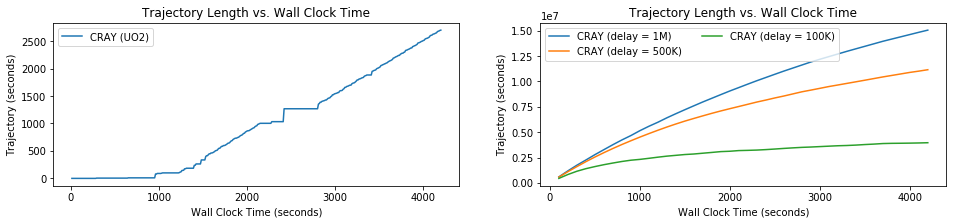

In [2]:
_, ax = plt.subplots(1, 2, figsize=(16, 3))
d = "../experiments/baseline-trinitite/"
ax[0].set_title("UO2 Input")
plot_times(ax[0], "CRAY (UO2)", d+"uo2")
ax[1].set_title("Nanoparticle Growth Input")
plot_times(ax[1], "CRAY (delay = 1M)",   d+"nano/delay1M")
plot_times(ax[1], "CRAY (delay = 500K)", d+"nano/delay500K")
plot_times(ax[1], "CRAY (delay = 100K)", d+"nano/delay100K")

Comparing the new nanoparticle growth simulation to the UO2 simulation:
1. Trajectory length is 2 orders of magnitude larger
2. Delay reduces trajectory length

Danny says:
> In this case, the particle is growing, so the calculation becomes progressively more expensive, hence the curving down of the simulation time vs wall clock time in the times.out.

> With this setup, the beginning of the run will be boring because small particles are quite stable, so not many transitions will occur and you won't be hitting the database much. So, the workers are indeed doing a lot of work, but it doesn't lead to much db access. Things will get more exciting for larger sizes. Try decreasing "Delay" by a factor of 10 (the particle will then grow 10 times faster). Things will pick up  quicker and you will see activity within your 1h running window. If you want even more action, you can decrease it by another factor of 10, but then the efficiency will become quite poor (which perhaps doesn't matter much if you only want to look at the behavior of the database).  

# Raw Performance Numbers (keyspace size and hotspots)
These statistics are pulled from the "semantic performance counters" that we littered throughout the `LocalStore` module [example](https://gitlab.com/mikesevilla3/parsplice/blob/trinitite-nanoparticle-nospawn/core/LocalStore.cpp#L548). Basically, we wrapped every `put/get()` call with debug statement that dumps the key. 

## Boring Parsing Info
The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the value is a tuple with parsed data in Python data frames. The `keyspace()` function reads the raw data and puts it into the dictionary:

```
dfs[(job name, op, task)] => (rawDF, countDF)
```

where `job name` is a human readable string that describes the job, `op` is the type of database operation, `task` is the MPI rank number, `rawDF` has keys and timestamps, and `countDF` has keys and counts (i.e. # of occurences). We save `countDF` because it takes forever to parse this data.

In [3]:
dfs = {}                                  # global data structure with parsed data
for op in ["DBMemoryPut", "DBMemoryGet"]: # parse data for these operations
    for t in ["01", "03", "04"]:          # parse data for these MPI ranks (or tasks)
        dfs[("UO2", op, -1)]       = keyspace(op, d+"uo2")
        dfs[("Delay 1M", op, t)]   = keyspace(op, d+"nano/delay1M", task=t)
        dfs[("Delay 500K", op, t)] = keyspace(op, d+"nano/delay500K", task=t)
        dfs[("Delay 100K", op, t)] = keyspace(op, d+"nano/delay100K", task=t)

DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=546)
DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=546)
DBMemoryPut delay1M task=03: nkeys=81, hottest key=10627150693849639731 (count=1)
DBMemoryPut delay500K task=03: nkeys=444, hottest key=10047642435126178895 (count=1)
DBMemoryPut delay100K task=03: nkeys=8716, hottest key=10000949668668174214 (count=1)
DBMemoryPut uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=546)
DBMemoryPut delay1M task=04: nkeys=100, hottest key=13397889897772269455 (count=106033)
DBMemoryPut delay500K task=04: nkeys=464, hottest key=14045287823504495930 (count=52932)
DBMemoryPut delay100K task=04: nkeys=8716, hottest key=7945113548248993750 (count=15627)
DBMemoryGet uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=1063)
DBMemoryGet uo2 task=04: nkeys=57, hottest key=15078487755110697300 (count=1063)
DBMemoryGet delay1M task=03: nkeys=81, hottest key=10627150693849639731 (count=

# Spatial Locality
Where keys reside and who services requests. Recall the ParSplice architecture looks like this:
<img src="pspice.png" width=400>

... where `S` is the splicer, `W`s are workers, and `WM` are work managers.

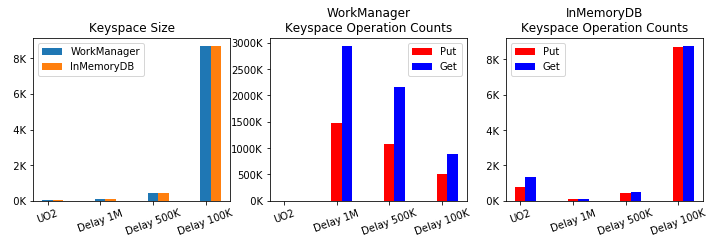

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_keyspace_size(ax[0], dfs, "DBMemoryPut", "04")
plot_keyspace_size(ax[0], dfs, "DBMemoryPut", "03", shift=0.2)
plot_keyspace_ops(ax[1], dfs, "DBMemoryPut", "04")
plot_keyspace_ops(ax[2], dfs, "DBMemoryPut", "03")
plot_keyspace_ops(ax[1], dfs, "DBMemoryGet", "04", shift=0.2, color='blue')
plot_keyspace_ops(ax[2], dfs, "DBMemoryGet", "03", shift=0.2, color='blue')

Conclusions (corresponds to each figure):
- **Keyspace Size**: keyspace size grows with less delay 
- **WorkManager Keyspace Operation Counts**: keyspace size is the same on InMemoryDB and WorkManager
- **InMemoryDB Keyspace Operation Counts**: WorkManager services the majority of `put/get()`s

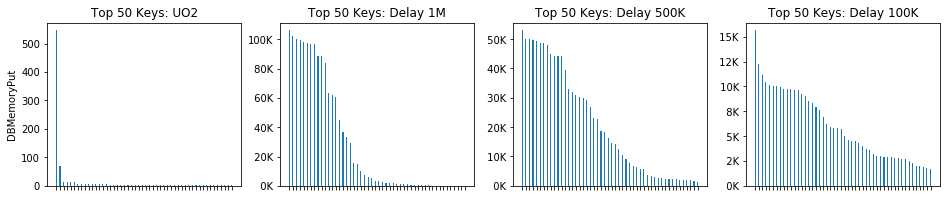

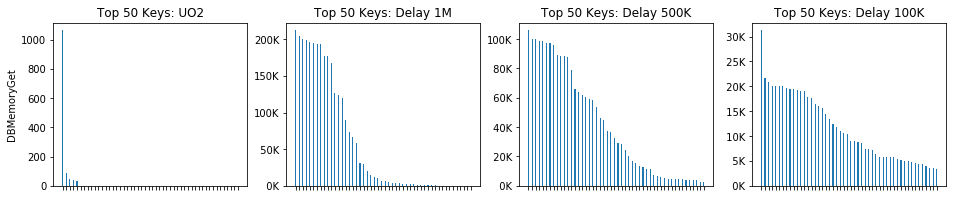

In [5]:
for op in ["DBMemoryPut", "DBMemoryGet"]:
    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    plot_keyspace(ax[0], dfs, ("UO2", op, -1))
    plot_keyspace(ax[1], dfs, ("Delay 1M", op, "04"))
    plot_keyspace(ax[2], dfs, ("Delay 500K", op, "04"))
    plot_keyspace(ax[3], dfs, ("Delay 100K", op, "04"))
    ax[0].set_ylabel(op)

Conclusions:
- **DBMemoryPut vs Get**: 2x more reads
- **From Left to Right**: Larger delays have hotter keys
- Many more hotspots than the UO2

# Temporal Locality
When keys are accessed:

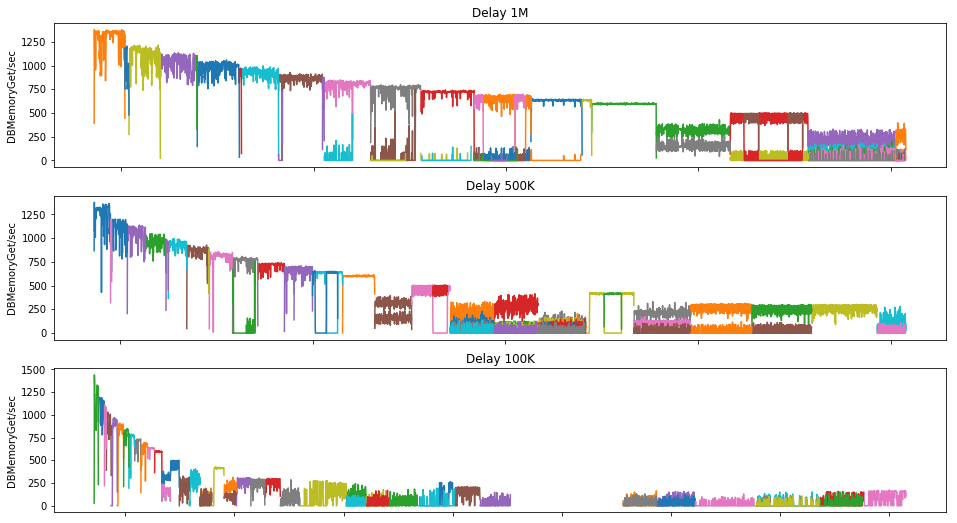

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))
plot_keytimes(ax[0], dfs, ("Delay 1M", "DBMemoryGet", "04"))
plot_keytimes(ax[1], dfs, ("Delay 500K", "DBMemoryGet", "04"))
plot_keytimes(ax[2], dfs, ("Delay 100K", "DBMemoryGet", "04"))

Conclusions: 
- keys are never re-accessed
- delay reduces the load on in-memoryDB
- Some keys are "colder" than others

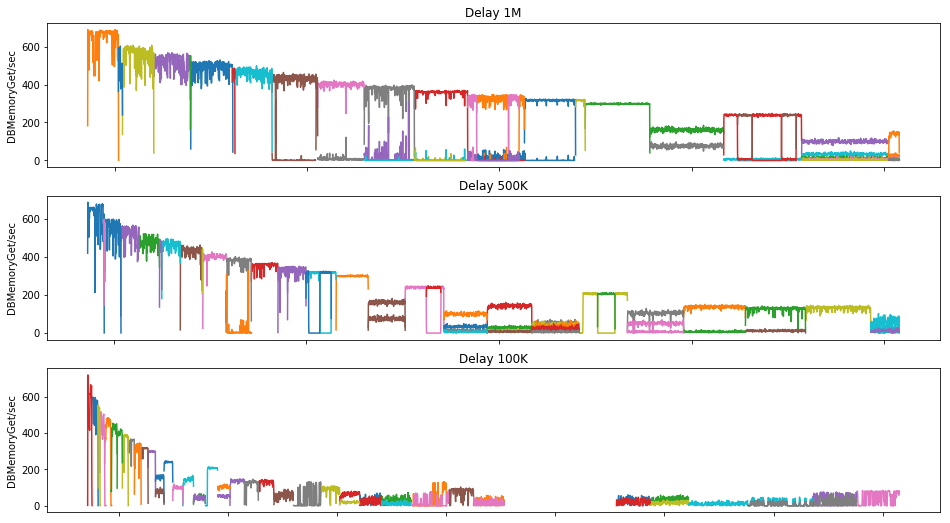

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))
plot_keytimes(ax[0], dfs, ("Delay 1M", "DBMemoryPut", "04"))
plot_keytimes(ax[1], dfs, ("Delay 500K", "DBMemoryPut", "04"))
plot_keytimes(ax[2], dfs, ("Delay 100K", "DBMemoryPut", "04"))

Conclusions:
- this is not as exciting as `get`
- WHY IS IT PUTTING THE SAME KEY?